In [37]:
import tensorflow as tf
import keras
from keras import layers
from random import randint
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from glob import glob
import os
from itertools import groupby
from dataclasses import dataclass

In [38]:
IMG_SIZE = (224, 224)
batch_size = 32
validation_split = 0.2

In [39]:
seed = randint(0, 2**32 - 1)

In [40]:
dataDir = "datasets/processed_binary_split_manual"
baseWeightsSavePath = "weights/best_binary_split_manual.keras"
baseFinetunedSavePath = "weights/best_finetuned_binary_split_manual.keras"

In [41]:
tf.config.list_physical_devices("GPU")

[]

In [57]:
@dataclass
class Session:
    id: str
    class_name: str
    image_paths: list[str]
    session_name: str
    label: int

class_names = ['close', 'open']

sessions = [
    Session(
        id=f"{class_name}_{session_name}",
        class_name=class_name,
        image_paths=list(image_paths),
        session_name=session_name,
        label=class_names.index(class_name),
    )
    for (_, __, class_name, session_name), image_paths in groupby(
        glob(f"{dataDir}/**/*.jpg", recursive=True),
        lambda path: tuple(os.path.normpath(path).split("\\")[:4]),
    )
]

In [ ]:
val_size = 0.15
test_size = 0.15

session_ids = [s.id for s in sessions]
labels = [s.label for s in sessions]

# First split: training vs temporary (val+test)
# We use stratification to maintain class balance
train_sessions, temp_sessions = train_test_split(
    session_ids,
    test_size=(val_size + test_size),
    stratify=labels,
    random_state=seed,
)

# Second split: val vs test from temporary sessions
# Adjust split size: we want val_size/(val_size+test_size) of temp
val_test_ratio = val_size / (val_size + test_size)
val_sessions, test_sessions = train_test_split(
    temp_sessions,
    test_size=(1 - val_test_ratio),  # This gives us the right proportion
    stratify=[label for sid, label in zip(session_ids, labels) if sid in temp_sessions],
    random_state=seed,
)

train_data = [s for s in sessions if s.id in train_sessions]
val_data = [s for s in sessions if s.id in val_sessions]
test_data = [s for s in sessions if s.id in test_sessions]

In [44]:
# Step 3: Create TensorFlow datasets
def create_dataset_from_sessions(session_data: list[Session], augment=False, shuffle=False):
    """Convert session data to a tf.data.Dataset."""
    all_image_paths = []
    all_labels = []

    # Flatten the session structure into individual images
    for session in session_data:
        all_image_paths.extend(session.image_paths)
        all_labels.extend([session.label] * len(session.image_paths))

    # Create TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((all_image_paths, all_labels))

    # Shuffle if needed (do this before mapping for better performance)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(all_image_paths), seed=seed)

    # Load and preprocess images
    def load_and_preprocess_image(path, label):
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, IMG_SIZE)
        image = keras.applications.mobilenet_v2.preprocess_input(image)
        return image, label

    dataset = dataset.map(
        load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE
    )

    # Apply augmentation only to training set
    if augment:
        augmentation_layers = keras.Sequential(
            [
                keras.layers.RandomFlip("horizontal_and_vertical"),
                keras.layers.RandomTranslation(0.2, 0.2, fill_mode="nearest"),
                keras.layers.RandomRotation(0.2),
                keras.layers.RandomZoom(0.1),
                keras.layers.RandomBrightness(0.1),
                keras.layers.RandomContrast(0.1),
            ]
        )

        def augment_image(image, label):
            image = augmentation_layers(image, training=True)
            return image, label

        dataset = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)

    # Batch and prefetch for performance
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset, len(all_image_paths)


In [45]:
train_ds, train_count = create_dataset_from_sessions(
    train_data, augment=True, shuffle=True
)
val_ds, val_count = create_dataset_from_sessions(val_data)
test_ds, test_count = create_dataset_from_sessions(test_data)

In [46]:
checkpoint_callback_base = keras.callbacks.ModelCheckpoint(
    filepath=baseWeightsSavePath,
    monitor="val_accuracy",  # You can use 'val_loss' for less overfitting
    save_best_only=True,  # Critical: only save if validation improves
    save_weights_only=False,  # Save entire model (architecture + weights)
    mode="max",  # 'max' for accuracy, 'min' for loss
    verbose=1,
)

checkpoint_callback_finetune = keras.callbacks.ModelCheckpoint(
    filepath=baseFinetunedSavePath,
    monitor="val_accuracy",  # You can use 'val_loss' for less overfitting
    save_best_only=True,  # Critical: only save if validation improves
    save_weights_only=False,  # Save entire model (architecture + weights)
    mode="max",  # 'max' for accuracy, 'min' for loss
    verbose=1,
)

# Callback 2: Early stopping to prevent overfitting
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,  # Stop after 5 epochs without improvement
    restore_best_weights=True,  # Keep the best weights when stopping
)

# Callback 3: Reduce learning rate when plateauing
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,  # Reduce learning rate by half
    patience=3,  # Wait 3 epochs
    min_lr=1e-7,  # Minimum learning rate
)

callbacks = [early_stop, reduce_lr]

In [47]:
train_close_count = sum(1 for s in test_data if s.class_name == 'close')
train_open_count = sum(1 for s in test_data if s.class_name == 'open')

In [48]:
total = train_count
close_weight = total / (2 * train_close_count)
open_weight = total / (2 * train_open_count)
class_weight = {0: close_weight, 1: open_weight}

In [49]:
base_model = keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,), include_top=False, weights="imagenet"
)
# Freeze the base model initially
base_model.trainable = False


In [50]:
model = keras.Sequential(
    [
        base_model,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)

In [51]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [ ]:
history = model.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    callbacks=[checkpoint_callback_base, *callbacks],
    class_weight=class_weight
)

In [53]:
model.load_weights(baseWeightsSavePath)

In [54]:
validation_loss, validation_accuracy = model.evaluate(test_ds)
print(f"Validation Accuracy: {validation_accuracy:.2%}")


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 449ms/step - accuracy: 0.8462 - loss: 0.5606
Validation Accuracy: 84.62%


In [ ]:
base_model.trainable = True

fine_tune = 40
for i, layer in enumerate(base_model.layers):
    layer.trainable = i >= len(base_model.layers) - fine_tune

# Recompile with lower learning rate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),  # Much smaller LR # pyright: ignore[reportArgumentType]
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

print(f"\nPhase 2: Fine-tuning last {fine_tune} layers...")
history_fine = model.fit(
    train_ds,
    initial_epoch=history.epoch[-1],
    epochs=30,
    validation_data=val_ds,
    callbacks=[checkpoint_callback_finetune, *callbacks],
)



Phase 2: Fine-tuning last 40 layers...
Epoch 15/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 732ms/step - accuracy: 0.5776 - loss: 0.6851
Epoch 15: val_accuracy improved from None to 0.65722, saving model to weights/best_finetuned_binary.keras

Epoch 15: finished saving model to weights/best_finetuned_binary.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 52s 914ms/step - accuracy: 0.5761 - loss: 0.6839 - val_accuracy: 0.6572 - val_loss: 0.6280 - learning_rate: 1.0000e-05
Epoch 16/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 735ms/step - accuracy: 0.5619 - loss: 0.6879
Epoch 16: val_accuracy did not improve from 0.65722
45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 876ms/step - accuracy: 0.5669 - loss: 0.6850 - val_accuracy: 0.6544 - val_loss: 0.6265 - learning_rate: 1.0000e-05
Epoch 17/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 772ms/step - accuracy: 0.5357 - loss: 0.6925
Epoch 17: val_accuracy did not improve from 0.65722
45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 916ms/step - accuracy: 0.5499 - loss: 0.6899 - val_accuracy: 0.6459 - val_loss: 0.6269 - learn

: 

: 

: 

In [ ]:
model.load_weights(baseFinetunedSavePath)


: 

: 

: 

In [61]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_ds:
    y_true.append(label_batch.numpy())

    pred = model.predict(image_batch)

    indices = np.argmax(pred, axis=-1)

    res = np.zeros_like(pred)

    np.put_along_axis(res, indices[:, None], 1, axis=-1)

    y_pred.append(res)

# convert the true and predicted labels into tensors
correct_labels = np.concat(y_true, axis=0)
predicted_labels = np.concat(y_pred, axis=0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


In [ ]:
predicted_labels

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

: 

: 

: 

In [ ]:
correct_labels

array([[0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],

: 

: 

: 

              precision    recall  f1-score   support

       close       0.00      0.00      0.00       107
        open       0.68      1.00      0.81       231

    accuracy                           0.68       338
   macro avg       0.34      0.50      0.41       338
weighted avg       0.47      0.68      0.55       338



d:\Projekty\misc\cat-flap\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Projekty\misc\cat-flap\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Projekty\misc\cat-flap\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


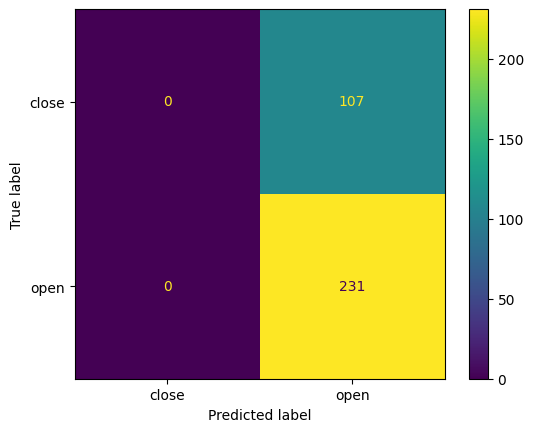

In [62]:
print(classification_report(correct_labels, predicted_labels,target_names=class_names))

cmat = confusion_matrix(
    correct_labels,
    predicted_labels,
    labels=[0, 1],
)

ConfusionMatrixDisplay(
    confusion_matrix=cmat,
    display_labels=class_names
).plot()
